In [4]:
from langchain_ollama import ChatOllama

local_llm = "llama3.2:3b"
llm = ChatOllama(model=local_llm, temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

In [5]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
)

# Create retriever
retriever = vectorstore.as_retriever(k=3)

USER_AGENT environment variable not set, consider setting it to identify your requests.


## Creating a LangChain Graph

In [18]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated


class GraphState(TypedDict):
    """dictionary that contains information we want to propagate to, and modify in, each graph node."""

    chat_message: str  # User question
    documents: List[str]  # List of retrieved documents from vector store or web search
    generation: str  # LLM generation
    web_search: str  # Binary decision to run web search
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]

### Prompt Instructions

In [42]:
router_instructions = """You are an expert at routing a user question to a vectorstore or quick-response.
The vectorstore contains documents related to chat related to various general topic wtih more depth and more tokens.                    
Use the vectorstore for questions on these topics. For all else, and especially small and generic topics .
Return JSON with single key, datasource, that is 'quick-response' or 'vectorstore' depending on the question.
"""
# You are a grader assessing relevance of a retrieved document to a user question.
# If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user chat message.
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question.
"""

# Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}.
# This carefully and objectively assess whether the document contains at least some information that is relevant to the question.
# Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""


doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here are few of the user chat message \n\n {chat_message}
Observe this carefully and give a binary score to indicate whether the document contains at least some information that is relevant to the question.
Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question.
"""

rag_prompt = """You are responding as a person to a chat response. Here is the context to use to answer the question:
{context} 
Think about this context carefully and give an appropriate response to the following set of chat messages: {chat_message}
Provide reply in a conversational manner using only the context provided. Use one sentence maximum.
"""

quick_response_prompt = """You are responding to a person's chat message.
Here is the chat message: {chat_message}
Its a generic chat message. So keep the response short and concise. Dont use more than 3 words.
"""

In [25]:
import json
from langchain_core.messages import HumanMessage, SystemMessage


test_web_search = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [
        HumanMessage(
            content="Who is favored to win the NFC Championship game in the 2024 season?"
        )
    ]
)
test_web_search_2 = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What are the models released today for llama3.2?")]
)
test_vector_store = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="Have you played valo before?")]
)
print(
    json.loads(test_web_search.content),
    json.loads(test_web_search_2.content),
    json.loads(test_vector_store.content),
)

{'datasource': 'vectorstore'} {'datasource': 'vectorstore'} {'datasource': 'vectorstore'}


### Langchain nodes

In [35]:
import json
from langchain.schema import Document
from langgraph.graph import END
from langchain_core.messages import HumanMessage, SystemMessage


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


def route_question(state):
    """Route question to web search or RAG"""

    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["chat_message"])]
    )
    source = json.loads(route_question.content)["datasource"]
    if source == "quick-response":
        print("---ROUTE QUESTION TO QUICK-RESPONSE---")
        return "quick-response"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


# Retrive documents from vector store
def retrieve(state):
    print("---RETRIEVE---")
    chat_message = state["chat_message"]

    documents = retriever.invoke(chat_message)
    return {"documents": documents}


# Grade retrieved documents from vector store
# def grade_documents(state):
#     """If any document is not relevant, we will set a flag to run web search"""

#     print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
#     chat_message = state["chat_message"]
#     documents = state["documents"]

#     # Score each doc
#     filtered_docs = []
#     for d in documents:
#         doc_grader_prompt_formatted = doc_grader_prompt.format(
#             document=d.page_content, chat_message=chat_message
#         )
#         result = llm_json_mode.invoke(
#             [SystemMessage(content=doc_grader_instructions)]
#             + [HumanMessage(content=doc_grader_prompt_formatted)]
#         )
#         grade = json.loads(result.content)["binary_score"]
#         # Document relevant
#         if grade.lower() == "yes":
#             print("---GRADE: DOCUMENT RELEVANT---")
#             filtered_docs.append(d)
#     return {"documents": filtered_docs}


# def decide_to_generate(state):
#     """Determines whether to generate an answer, or add web search"""

#     print("---ASSESS GRADED DOCUMENTS---")
#     question = state["question"]
#     web_search = state["web_search"]
#     filtered_documents = state["documents"]

#     if web_search == "Yes":
#         # All documents have been filtered check_relevance
#         # We will re-generate a new query
#         print(
#             "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
#         )
#         return "websearch"
#     else:
#         # We have relevant documents, so generate answer
#         print("---DECISION: GENERATE---")
#         return "generate"


def generate(state):
    """Generate answer using RAG on retrieved documents"""
    print("---GENERATE---")
    chat_message = state["chat_message"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(
        context=docs_txt, chat_message=chat_message
    )
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}


# Web search based based on the question
def quick_response(state):
    """Generate answer using quick-response"""
    print("---GENERATE---")
    chat_message = state["chat_message"]
    # documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    # docs_txt = format_docs(documents)
    rag_prompt_formatted = quick_response_prompt.format(chat_message=chat_message)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}


# def grade_generation_v_documents_and_question(state):
#     """Determines whether the generation is grounded in the document and answers question"""

#     print("---CHECK HALLUCINATIONS---")
#     question = state["question"]
#     documents = state["documents"]
#     generation = state["generation"]
#     max_retries = state.get("max_retries", 3)  # Default to 3 if not provided

#     hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
#         documents=format_docs(documents), generation=generation.content
#     )
#     result = llm_json_mode.invoke(
#         [SystemMessage(content=hallucination_grader_instructions)]
#         + [HumanMessage(content=hallucination_grader_prompt_formatted)]
#     )
#     grade = json.loads(result.content)["binary_score"]

#     # Check hallucination
#     if grade == "yes":
#         print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
#         # Check question-answering
#         print("---GRADE GENERATION vs QUESTION---")
#         # Test using question and generation from above
#         answer_grader_prompt_formatted = answer_grader_prompt.format(
#             question=question, generation=generation.content
#         )
#         result = llm_json_mode.invoke(
#             [SystemMessage(content=answer_grader_instructions)]
#             + [HumanMessage(content=answer_grader_prompt_formatted)]
#         )
#         grade = json.loads(result.content)["binary_score"]
#         if grade == "yes":
#             print("---DECISION: GENERATION ADDRESSES QUESTION---")
#             return "useful"
#         elif state["loop_step"] <= max_retries:
#             print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
#             return "not useful"
#         else:
#             print("---DECISION: MAX RETRIES REACHED---")
#             return "max retries"
#     elif state["loop_step"] <= max_retries:
#         print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
#         return "not supported"
#     else:
#         print("---DECISION: MAX RETRIES REACHED---")
#         return "max retries"

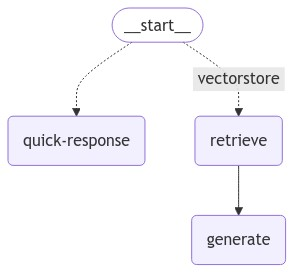

In [37]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("quick-response", quick_response)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
# workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "quick-response": "quick-response",
        "vectorstore": "retrieve",
    },
)
# workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "generate")
# workflow.add_edge("grade_documents", "generate")
# workflow.add_conditional_edges(
#     "grade_documents",
#     decide_to_generate,
#     {
#         "websearch": "websearch",
#         "generate": "generate",
#     },
# )
# workflow.add_conditional_edges(
#     "generate",
#     grade_generation_v_documents_and_question,
#     {
#         "not supported": "generate",
#         "useful": END,
#         "not useful": "websearch",
#         "max retries": END,
#     },
# )

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
inputs = {"chat_message": "hi"}
for event in graph.stream(inputs, stream_mode="values"):

    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO QUICK-RESPONSE---
{'chat_message': 'hi', 'loop_step': 0}
---GENERATE---
{'chat_message': 'hi', 'generation': AIMessage(content='Hello how are you?', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-09-27T18:24:11.782991Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 1110838000, 'load_duration': 100525416, 'prompt_eval_count': 65, 'prompt_eval_duration': 545584000, 'eval_count': 6, 'eval_duration': 455500000}, id='run-766f275f-04c7-465d-b7d7-7bb3383cb6d9-0', usage_metadata={'input_tokens': 65, 'output_tokens': 6, 'total_tokens': 71}), 'loop_step': 1}


In [47]:
inputs = {
    "chat_message": "What do you think about controllers in valorant?",
}

events = []

for event in graph.stream(inputs, stream_mode="values"):
    events.append(event)
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'chat_message': 'What do you think about controllers in valorant?', 'loop_step': 0}
---RETRIEVE---
{'chat_message': 'What do you think about controllers in valorant?', 'documents': [Document(metadata={'id': 'bd992550-c5ef-4ff2-9484-c72d5dfeeb7e', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content='Resources:\n1. Internet access for searche

In [40]:
events

[{'chat_message': 'What do you think about valorant?', 'loop_step': 0},
 {'chat_message': 'What do you think about valorant?',
  'documents': [Document(metadata={'id': 'f98dc9ca-38e4-4ea4-a0a6-d78a141bfe21', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content='Reflection mechanism: synthesizes memories into higher level inferences over time and guides the agent’s future behavior. They are 

In [48]:
events[-1]["generation"]

AIMessage(content="I'm not really sure what's going on with the controllers in Valorant, I've been too busy trying to figure out why my agent is hallucinating in AlfWorld Env.", additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-09-27T18:36:00.823945Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 9803466250, 'load_duration': 54178500, 'prompt_eval_count': 1026, 'prompt_eval_duration': 6103310000, 'eval_count': 37, 'eval_duration': 3638152000}, id='run-7eb9ae04-e22c-4e28-8479-f2ac09d8a9db-0', usage_metadata={'input_tokens': 1026, 'output_tokens': 37, 'total_tokens': 1063})